In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Load the dataset
data = pd.read_csv(r"../data/train.csv")
data.columns = [col.strip().lower() for col in data.columns]
print(f"The shape of the train data: {data.shape}")

# Separate features and target variable
X = data.drop('class', axis=1)
y = data['class']

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

The shape of the train data: (150000, 32)


In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

In [10]:
# autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Train the autoencoder on the majority class
X_train_non_fraud = X_train[y_train == 0]
autoencoder.fit(X_train_non_fraud, X_train_non_fraud,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test),
                verbose=1)

Epoch 1/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.9569 - val_loss: 0.8728
Epoch 2/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8382 - val_loss: 0.8058
Epoch 3/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7784 - val_loss: 0.7728
Epoch 4/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7431 - val_loss: 0.7495
Epoch 5/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7371 - val_loss: 0.7360
Epoch 6/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7233 - val_loss: 0.7268
Epoch 7/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7010 - val_loss: 0.7192
Epoch 8/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6986 - val_loss: 0.7136
Epoch 9/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7056 - val_loss: 0.7094
Epoch 10/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6955 - val_loss: 0.7058
Epoch 11/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6798 - val_loss: 0.7028
Epoch 12/100
410/410 ━━━━━━━━━━━━━━━━━━━

In [12]:
# Predict the reconstruction error on the test set
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


In [13]:
# Set a threshold for reconstruction error
threshold = np.percentile(mse, 95)

# Classify the transactions
y_pred = (mse > threshold).astype(int)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     44919
           1       0.02      0.46      0.03        81

    accuracy                           0.95     45000
   macro avg       0.51      0.70      0.50     45000
weighted avg       1.00      0.95      0.97     45000



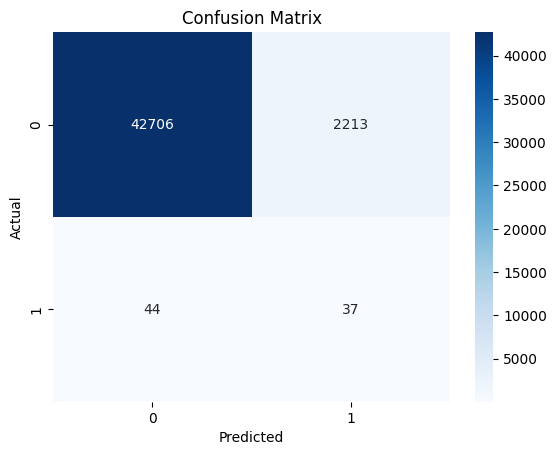

In [14]:
# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# ROC AUC Score
roc_auc = roc_auc_score(y_test, mse)
print(f'Autoencoder ROC AUC: {roc_auc}')

Autoencoder ROC AUC: 0.7651861141549988


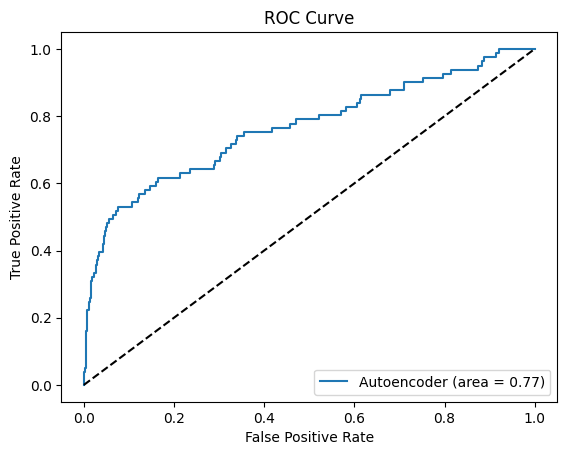

In [16]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mse)
plt.plot(fpr, tpr, label='Autoencoder (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## final submission

In [7]:
train = pd.read_csv(r"../data/train.csv")
test = pd.read_csv(r"../data/test.csv")

train.columns = [col.strip().lower() for col in train.columns]
test.columns = [col.strip().lower() for col in test.columns]

In [8]:
X_train = train.drop(['class'], axis=1)
y_train = train['class']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test)

X_train_non_fraud = X_train_scaled[y_train == 0]

In [10]:
input_dim = X_train_non_fraud.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(X_train_non_fraud, X_train_non_fraud,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_split=0.2,
                verbose=1)

Epoch 1/100
533/533 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.8666 - val_loss: 1.0245
Epoch 2/100
533/533 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7560 - val_loss: 0.9888
Epoch 3/100
533/533 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.7138 - val_loss: 0.9652
Epoch 4/100
533/533 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7043 - val_loss: 0.9477
Epoch 5/100
533/533 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6853 - val_loss: 0.9281
Epoch 6/100
533/533 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6817 - val_loss: 0.9121
Epoch 7/100
533/533 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6606 - val_loss: 0.9031
Epoch 8/100
533/533 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6627 - val_loss: 0.8991
Epoch 9/100
533/533 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6388 - val_loss: 0.8949
Epoch 10/100
533/533 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6629 - val_loss: 0.8903
Epoch 11/100
533/533 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6446 - val_loss: 0.8888
Epoch 12/100
533/533 ━━━━━━━━━━━━━━━━━━━━

In [11]:
test_pred = autoencoder.predict(X_test_scaled)
mse_test = np.mean(np.power(X_test_scaled - test_pred, 2), axis=1)

mse_min, mse_max = mse_test.min(), mse_test.max()
fraud_prob = (mse_test - mse_min) / (mse_max - mse_min)

3561/3561 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


In [13]:
test['Class'] = fraud_prob.round(2)
submission = test[['id', 'Class']]
submission.to_csv(r"../data/submission_with_autoencoder.csv", index=False)